# Cornershop Data Science Test

Author: Francisco Mena

In this notebook I design a machine learning model to predict the delivery times,
as part of the application for the data science position at Cornershop

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Set the seed to assure reproducibility
semilla = 2077
np.random.seed(semilla)


Now some data exploration to get familiar with the data to use for modeling.

First, the info on the products:

In [3]:
#Getting familiar with the data
dforderprod = pd.read_csv("data\order_products.csv")

dforderprod.dtypes
#checking for nans
print(dforderprod.isna().sum())
print('\n')

#number of orders: 9978
print(dforderprod["order_id"].nunique())
print('\n')
#number of products: 15422
print(dforderprod["product_id"].nunique())
print('\n')
#quantity: up to a 100 units bought, a minimum of 0.05, perhaps refers to weight
print(dforderprod["quantity"].describe())
print('\n')

print(dforderprod.loc[dforderprod["quantity"]<1, "buy_unit"].value_counts())
#Indeed, quantities below 1 refer to weight, items bought in bulk

order_id      0
product_id    0
quantity      0
buy_unit      0
dtype: int64


9978


15422


count    198500.000000
mean          1.824126
std           1.905529
min           0.055000
25%           1.000000
50%           1.000000
75%           2.000000
max         100.000000
Name: quantity, dtype: float64


KG    10005
Name: buy_unit, dtype: int64


Now let's look at the orders:

In [4]:
dforder = pd.read_csv("data\orders.csv")
dforder.dtypes
print(dforder.isna().sum())
#2000 nans = final set
print('\n')

print(dforder["order_id"].duplicated().sum())
print('\n')

#Minimum latitude is in Chiguayante, BioBio
print(dforder.loc[dforder["lat"].argmin()][["lat", "lng"]])
print('\n')

#Max latitude is in La Serena, Coquimbo
print(dforder.loc[dforder["lat"].argmax()][["lat", "lng"]])
print('\n')

#Min longitude is in San Pedro de la Paz, BioBio
print(dforder.loc[dforder["lng"].argmin()][["lat", "lng"]])
print('\n')

#Max longiture is in Barnechea, RM
print(dforder.loc[dforder["lng"].argmax()][["lat", "lng"]])

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      2000
dtype: int64


0


lat   -36.942135
lng   -73.023604
Name: 2578, dtype: object


lat   -29.833517
lng   -71.272555
Name: 5040, dtype: object


lat   -36.854938
lng    -73.14428
Name: 2689, dtype: object


lat   -33.371081
lng   -70.453728
Name: 6104, dtype: object


In [5]:
#Convert to datetime format
dforder["promised_time"] = pd.to_datetime(dforder["promised_time"])
print(dforder["promised_time"].min())
print(dforder["promised_time"].max())
#All orders are between 18-20 Oct '19

dforder["on_demand"].value_counts()
print(dforder["on_demand"].value_counts(normalize = True))
#55% vs 45% on demand

#number of shoppers: 2864
print(dforder["shopper_id"].nunique())

#476 different stores
dforder["store_branch_id"].nunique()
dforder["store_branch_id"].value_counts()[:10]
print(dforder["store_branch_id"].value_counts(normalize = True)[:5].sum())
#TFive stores cover over 50% of the orders

#between 12 and 305 minutes (5 hours)
print(dforder["total_minutes"].describe())

2019-10-18 19:01:00+00:00
2019-10-20 00:00:00+00:00
False    0.5453
True     0.4547
Name: on_demand, dtype: float64
2864
0.5428
count    8000.000000
mean       81.106130
std        34.720837
min        11.969489
25%        55.225480
50%        74.731672
75%       100.273498
max       304.190303
Name: total_minutes, dtype: float64


### Feature engineering
I need to build features that help predict the delivery time.

Frequent store or not so common store? Let's classify the stores according to
how often clients buy from them

In [6]:
common_store = dforder["store_branch_id"].isin(dforder["store_branch_id"].value_counts(normalize = True)[:5].index)

dforder["common_store"] = common_store
dforder["common_store"] = dforder["common_store"].map({True:1, False:0})

print(dforder["common_store"].value_counts())

1    5428
0    4572
Name: common_store, dtype: int64


Now let's build some features from the time data

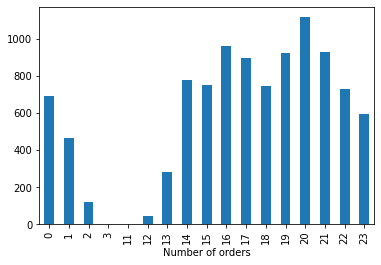

In [7]:
plt.figure()
dforder["promised_time"].dt.hour.value_counts().sort_index().plot.bar()
plt.xlabel("Hour of day")
plt.xlabel("Number of orders")
plt.show()

No orders between 3am and 11am

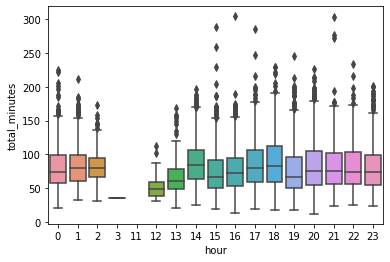

In [8]:
dfaux = dforder.copy()
dfaux["hour"] = dfaux["promised_time"].dt.hour
dforder.dtypes


plt.figure()
sns.boxplot(data = dfaux, x = "hour", y = "total_minutes")
plt.show()

There isn't a strong correlation between time of day and total minutes,
except that nothing much happens before noon.

Let's classify the hour of day according into categories. It might make an
important difference if we order something for lunch instead of around dinner time,
or at midnight.

In [9]:
def timeofday(t):
    if (t>=22)|(t<4):
        return "night"
    elif (t>=4)&(t<15):
        return "morning_n_lunch"
    elif (t>=15)&(t<19):
        return "afternoon"
    elif (t>=19)&(t<22):
        return "evening"
    else:
        return np.nan

dforder["hourofday"] = dforder["promised_time"].dt.hour + dforder["promised_time"].dt.minute/60

dforder["timeofday"] = [timeofday(x) for x in dforder["hourofday"]]
dforder[["hourofday", "timeofday"]]
dforder["timeofday"].isna().sum()
print( dforder["timeofday"].value_counts())

afternoon          3347
evening            2963
night              2587
morning_n_lunch    1103
Name: timeofday, dtype: int64


Now, hour of day is not cyclical,  00:00 follows 24:00, which is not continuous.
Let's make time a cyclical feature:

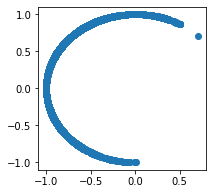

In [10]:
dforder["hourofday_x"] = np.sin( 2 * np.pi * dforder["hourofday"] / 24 )
dforder["hourofday_y"] = np.cos( 2 * np.pi * dforder["hourofday"] / 24 )

plt.figure(figsize = (3,3))
plt.scatter(dforder["hourofday_x"], dforder["hourofday_y"])
plt.show()

Now the time is a cyclical feature and will be more easily interpreted by the machine learning model.
The white space in the circle corresponds to the lack of data between near 3am and 11am.

Let's look at the info on the shoppers:

In [11]:
dfshopper = pd.read_csv("data/shoppers.csv")
#there are seveal nan
print( dfshopper.isna().sum() )
print('\n')

dfshopper.dtypes

#no duplicated ids
print(dfshopper["shopper_id"].duplicated().sum())
print('\n')

print(dfshopper["shopper_id"].nunique()) #2864 shoppers
print('\n')

print(dfshopper["seniority"].value_counts())
print('\n')

shopper_id         0
seniority          0
found_rate       101
picking_speed      0
accepted_rate     27
rating            84
dtype: int64


0


2864


6c90661e6d2c7579f5ce337c3391dbb9    1643
50e13ee63f086c2fe84229348bc91b5b     719
41dc7c9e385c4d2b6c1f7836973951bf     440
bb29b8d0d196b5db5a5350e5e3ae2b1f      62
Name: seniority, dtype: int64




Only four seniority types

In [12]:
print(dfshopper["found_rate"].describe()) #between 74% and 97%
dfshopper["found_rate"].isna().sum()/len(dfshopper) #3% are nan
print('\n')

print(dfshopper["picking_speed"].describe()) #between .6 and 7.
print('\n')

print(dfshopper["accepted_rate"].describe()) #between 0.24 and 1
dfshopper["accepted_rate"].isna().sum()/len(dfshopper) #1% are nan
print('\n')

print(dfshopper["rating"].describe()) #between 3.8 and 5.0
dfshopper["rating"].isna().sum()/len(dfshopper) #3% are nan
print('\n')

count    2763.000000
mean        0.861082
std         0.031038
min         0.737300
25%         0.842900
50%         0.863900
75%         0.881950
max         0.971000
Name: found_rate, dtype: float64


count    2864.000000
mean        1.762392
std         0.665962
min         0.650000
25%         1.290000
50%         1.580000
75%         2.120000
max         7.040000
Name: picking_speed, dtype: float64


count    2837.000000
mean        0.908276
std         0.107911
min         0.240000
25%         0.880000
50%         0.944444
75%         1.000000
max         1.000000
Name: accepted_rate, dtype: float64


count    2780.000000
mean        4.848428
std         0.133011
min         3.880000
25%         4.800000
50%         4.880000
75%         4.960000
max         5.000000
Name: rating, dtype: float64




The "seniority" variable has some strange names. Let's map seniority for clarity

In [13]:
dfshopper["seniority"].value_counts()
#Only four seniority types
mapeo = {"6c90661e6d2c7579f5ce337c3391dbb9":"A",
 "50e13ee63f086c2fe84229348bc91b5b":"B",
 "41dc7c9e385c4d2b6c1f7836973951bf":"C",
 "bb29b8d0d196b5db5a5350e5e3ae2b1f":"D"}

dfshopper["seniority"] = dfshopper["seniority"].map(mapeo)
dfshopper["seniority"].value_counts()

A    1643
B     719
C     440
D      62
Name: seniority, dtype: int64

Based on the value count, I could make some assumptions on which categories has
more seniority than others, but better to not make assumptions without having more information.

Let's build features now for the picking speed. The median is around 1.5 minutes, so let's
separate shipping speed into "slow" and "fast" shoppers.

In [14]:
print( dfshopper["picking_speed"].describe()) #between .6 and 7.
dfshopper["picking_speed_fast"] = dfshopper["picking_speed"]<2

dfshopper["picking_speed_fast"] = dfshopper["picking_speed_fast"].map({True:1, False:0})
dfshopper["picking_speed_fast"].value_counts()

count    2864.000000
mean        1.762392
std         0.665962
min         0.650000
25%         1.290000
50%         1.580000
75%         2.120000
max         7.040000
Name: picking_speed, dtype: float64


1    2010
0     854
Name: picking_speed_fast, dtype: int64

Now let's look at the info on the stores

In [16]:
dfstore = pd.read_csv("data/storebranch.csv")
dfstore.isna().sum() #no nans

dfstore.dtypes

#no duplicates
dfstore["store_branch_id"].duplicated().sum()
print( dfstore["store_branch_id"].nunique()) #476 stores
print('\n')

dfstore["store_id"].duplicated().sum()  #255 duplicates
print( dfstore["store_id"].nunique()) #221 stores
dfstore["store_id"].value_counts()
print('\n')

#Minimum latitude is in Chiguayante, BioBio
print( dfstore.loc[dfstore["lat"].argmin()][["lat", "lng"]])
print('\n')

#Max latitude is in La Serena, Coquimbo
print( dfstore.loc[dfstore["lat"].argmax()][["lat", "lng"]])
print('\n')

#Min longitude is in San Pedro de la Paz, BioBio
print( dfstore.loc[dfstore["lng"].argmin()][["lat", "lng"]])
print('\n')

#Max longiture is in Barnechea, RM
print( dfstore.loc[dfstore["lng"].argmax()][["lat", "lng"]])
print('\n')

#change names to merge dataframes
dfstore.rename(columns = {"lat":"lat_store", "lng":"lng_store"}, inplace = True)

476


221


lat   -36.904347
lng   -73.031379
Name: 163, dtype: object


lat   -29.901425
lng   -71.257707
Name: 69, dtype: object


lat   -36.838835
lng    -73.09666
Name: 247, dtype: object


lat   -33.363976
lng   -70.492256
Name: 399, dtype: object




Let's merge some of the dataframes before we continue with feature engineering

In [17]:
dforder.dtypes
dforderprod.dtypes
dfshopper.dtypes
dfstore.dtypes

df = pd.merge(dforder, dfshopper, how = 'left', left_on = 'shopper_id' ,right_on = 'shopper_id')
df.isna().sum() #nans increase after merge

df = pd.merge(df, dfstore, how = 'left', left_on = 'store_branch_id' ,right_on = 'store_branch_id')
df.isna().sum()


order_id                 0
lat                      0
lng                      0
promised_time            0
on_demand                0
shopper_id               0
store_branch_id          0
total_minutes         2000
common_store             0
hourofday                0
timeofday                0
hourofday_x              0
hourofday_y              0
seniority                0
found_rate             200
picking_speed            0
accepted_rate           46
rating                 163
picking_speed_fast       0
store_id                 0
lat_store                0
lng_store                0
dtype: int64

Some more Feature engineering:

Let's build the Distance between store and delivery

Eucledian distance would work since stores and deliveries are close,
but let's be thorough in the calculation anyway.
I'll use this library https://pypi.org/project/haversine/

In [18]:
import haversine as hs
loc1 = [(x,y) for x,y in zip(df["lat"], df["lng"])]
loc2 = [(x,y) for x,y in zip(df["lat_store"], df["lng_store"])]
distance = [hs.haversine(x,y) for x,y in zip(loc1,loc2 )]   #distance in km

df["distance"] = distance

print( df["distance"].describe() )

count    10000.000000
mean         2.890928
std          1.833382
min          0.076491
25%          1.593173
50%          2.504041
75%          3.925591
max         16.672794
Name: distance, dtype: float64


This is the straight distance between store and delivery. The distance
the shopper will travel is certainly longer,
but it helps as a proxy of how far they need to travel.

It would be great to have more info on the locations, like the city where they are.
let's use this library:
https://geopy.readthedocs.io

From the coordinates one can obtain the city.

In [19]:
coords = ["{},{}".format(x, y) for x,y in zip(df["lat"], df["lng"])]
coords = pd.DataFrame(data = coords, columns = ["coordinates"])


In [20]:
"""
####### I've already run the following part and saved the results to a file.
####### Since it takes several hours to run, I comment it here

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from datetime import datetime

locations = []
place = []
start = datetime.now()
for kk in range(len(coords)):
# for kk in range(80, len(coords)):
# for kk in range(7397, len(coords)):

    print(kk)

    app = "testapp" + str(kk)
    geolocator = Nominatim(user_agent= app)


    ans = geolocator.reverse( coords.iloc[kk] )

    if "city" in ans.raw['address'].keys():
        place.append("city")
        locations.append(  ans.raw['address']["city"]  )

    elif "suburb" in ans.raw['address'].keys():
        place.append("suburb")
        locations.append(  ans.raw['address']["suburb"]  )

    elif "town" in ans.raw['address'].keys():
        place.append("town")
        locations.append(  ans.raw['address']["town"]  )

    elif "neighbourhood" in ans.raw['address'].keys():
        place.append("neighbourhood")
        locations.append(  ans.raw['address']["neighbourhood"]  )

    else:
        place.append(np.nan)
        locations.append(np.nan)


end = datetime.now()
print(end - start)
# location = geolocator.reverse("{},{}".format(loc2[0][0], loc2[0][1]))

df_locations = pd.DataFrame({"comuna":locations, "place_type":place[:-1]})
df_locations.isna().sum()
df_locations["comuna"].value_counts().sort_index()
df_locations["place_type"].value_counts()

df_locations.to_csv("comunas_from_coordinates.csv")

"""

'\n####### I\'ve already run the following part and saved the results to a file.\n####### Since it takes several hours to run, I comment it here\n\nfrom geopy.geocoders import Nominatim\nfrom geopy.extra.rate_limiter import RateLimiter\n\nfrom datetime import datetime\n\nlocations = []\nplace = []\nstart = datetime.now()\nfor kk in range(len(coords)):\n# for kk in range(80, len(coords)):\n# for kk in range(7397, len(coords)):\n\n    print(kk)\n\n    app = "testapp" + str(kk)\n    geolocator = Nominatim(user_agent= app)\n\n\n    ans = geolocator.reverse( coords.iloc[kk] )\n\n    if "city" in ans.raw[\'address\'].keys():\n        place.append("city")\n        locations.append(  ans.raw[\'address\']["city"]  )\n\n    elif "suburb" in ans.raw[\'address\'].keys():\n        place.append("suburb")\n        locations.append(  ans.raw[\'address\']["suburb"]  )\n\n    elif "town" in ans.raw[\'address\'].keys():\n        place.append("town")\n        locations.append(  ans.raw[\'address\']["town"

In [ ]:
"""
df.columns
coords_store = ["{},{}".format(x, y) for x,y in zip(df["lat_store"], df["lng_store"])]
coords_store = pd.DataFrame(data = coords_store, columns = ["coordinates"])


locations_store = []
place_store = []

start = datetime.now()

# for kk in range(len(coords_store)):
# for kk in range(636,len(coords_store)):
for kk in range(2041,len(coords_store)):

    print(kk)

    app = "testapp" + str(kk)
    geolocator = Nominatim(user_agent= app)


    ans = geolocator.reverse( coords.iloc[kk] )

    if "city" in ans.raw['address'].keys():
        place_store.append("city")
        locations_store.append(  ans.raw['address']["city"]  )

    elif "suburb" in ans.raw['address'].keys():
        place_store.append("suburb")
        locations_store.append(  ans.raw['address']["suburb"]  )

    elif "town" in ans.raw['address'].keys():
        place_store.append("town")
        locations_store.append(  ans.raw['address']["town"]  )

    elif "neighbourhood" in ans.raw['address'].keys():
        place_store.append("neighbourhood")
        locations_store.append(  ans.raw['address']["neighbourhood"]  )

    else:
        place_store.append(np.nan)
        locations_store.append(np.nan)


end = datetime.now()
print(end - start)



df_locations_store = pd.DataFrame({"comuna":locations_store, "place_type":place_store})
df_locations_store.isna().sum()
df_locations_store["comuna"].value_counts().sort_index()
df_locations_store["place_type"].value_counts()

df_locations_store.to_csv("Stores_comunas_from_coordinates.csv")

"""

Having obtained the part of the city where the stores and clients are located,
the results are saved to a file so that they can be used without having to run the code again.

In [21]:
df_locations = pd.read_csv("comunas_from_coordinates.csv", index_col=0)
df_locations_store = pd.read_csv("Stores_comunas_from_coordinates.csv", index_col=0)

#Let's merge the results
df["comuna_client"] = df_locations["comuna"]
df["comuna_store"] = df_locations_store["comuna"]

In [22]:
df["comuna_client"].value_counts()
df["comuna_store"].value_counts()

(df["comuna_client"] != df["comuna_store"]).sum()

0

All orders and stores are in the same comuna!
That means I can simply use one feature instead of both

Let's also group comunas that don't appear much into one group.

In [23]:
df.columns
df.drop(["comuna_store"], axis = 1, inplace= True)
df.rename(columns = {"comuna_client": "comuna"}, inplace = True)


#Now I group rare comunas into one same group
df["comuna"].value_counts()
rare_comunas = df["comuna"].value_counts().loc[ df["comuna"].value_counts()<100  ].index

df["comuna"] = ["rare_comuna" if x in rare_comunas else x for x in df["comuna"]]

df["comuna"].value_counts()

Las Condes      2976
Lo Barnechea    1640
Vitacura        1338
Colina           819
rare_comuna      800
Providencia      696
Ñuñoa            460
La Reina         370
Viña del Mar     281
Santiago         197
Peñalolén        161
La Florida       145
Huechuraba       117
Name: comuna, dtype: int64

Now let's look at the data on the products

In [24]:
dforderprod.dtypes
print( dforderprod["product_id"].nunique())
print(dforderprod["order_id"].nunique())

15422
9978


In [25]:
### FEATURE: number of products per order
num_unique_products = dforderprod.groupby("order_id")["product_id"].nunique()

# first separate between bulk and unit items
dfbulk = dforderprod.loc[dforderprod["buy_unit"] == "KG"].copy()
dfunit = dforderprod.loc[dforderprod["buy_unit"] == "UN"].copy()

### FEATURE: weight bought
tot_weight = dfbulk.groupby("order_id")["quantity"].sum()
print( tot_weight.describe())

### FEATURE: number of items bought
num_tot_products = dfunit.groupby("order_id")["quantity"].sum()
num_tot_products.describe()


count    6332.000000
mean        2.738629
std         2.736629
min         0.055000
25%         0.948000
50%         1.926000
75%         3.602000
max        32.492000
Name: quantity, dtype: float64


count    9900.00000
mean       34.82303
std        33.15926
min         1.00000
25%        11.00000
50%        26.00000
75%        49.00000
max       335.00000
Name: quantity, dtype: float64

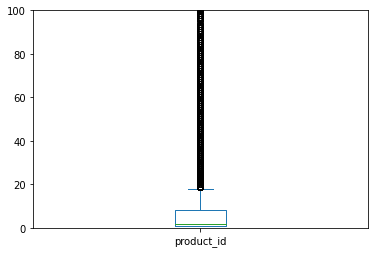

In [26]:
#Frequency of items bougth
plt.figure()
dforderprod["product_id"].value_counts().plot.box()
plt.ylim(0,100)
plt.show()

Most items were bought less than 20 times, but some items were bought many times.
Let's classify items according to how often they were bought.

In [27]:
dforderprod["product_id"].value_counts(normalize = True)

item_data = dforderprod["product_id"].value_counts()
item_data.describe()

count    15422.000000
mean        12.871223
std         49.588740
min          1.000000
25%          1.000000
50%          2.000000
75%          8.000000
max       2073.000000
Name: product_id, dtype: float64

Let's classify items according to frequency bought

In [28]:
item_data = item_data.to_frame("frequency")

#If an item has been bought more than 8 times it's normal, otherwise it's rare
item_data.loc[item_data["frequency"]<=8]
item_data.loc[item_data["frequency"]>8]
item_data.loc[item_data["frequency"]<=8, "freq_type"] = "FREQ_rare"
item_data.loc[item_data["frequency"]>8, "freq_type"] = "FREQ_normal"
item_data["freq_type"].value_counts()
item_data.rename_axis("product_id", axis = 0, inplace = True)

dforderprod.columns
dforderprod = pd.merge(dforderprod, item_data, how = "left", left_on = "product_id", right_on = "product_id")

dforderprod.loc[dforderprod["buy_unit"]=="KG", "quantity"].describe()

count    17846.000000
mean         0.971702
std          0.728834
min          0.055000
25%          0.498000
50%          0.835000
75%          1.200000
max         16.250000
Name: quantity, dtype: float64

In [29]:
dforderprod["freq_type"].value_counts()

FREQ_normal    171028
FREQ_rare       27472
Name: freq_type, dtype: int64

Besides classifying products according to how often they're bought,
we can also look at how much we buy per product, too much? too little?

In [30]:
#FIRST UNIT STUFF
median_quantity_bought = dfunit.groupby("product_id")["quantity"].median()
median_quantity_bought.describe()
median_quantity_bought.loc[median_quantity_bought<2]
median_quantity_bought.loc[median_quantity_bought>2]
median_quantity_bought.loc[median_quantity_bought>4]

median_quantity_bought = median_quantity_bought.to_frame("quantity_bought")
median_quantity_bought.loc[median_quantity_bought["quantity_bought"]<2, "amount_bought"] = "Q_a_little"
median_quantity_bought.loc[(median_quantity_bought["quantity_bought"]>=2) & (median_quantity_bought["quantity_bought"]<4), "amount_bought"] = "Q_some"
median_quantity_bought.loc[median_quantity_bought["quantity_bought"]>=4, "amount_bought"] = "Q_tons"
median_quantity_bought["amount_bought"].value_counts()
median_quantity_bought["amount_bought"].value_counts(normalize = True)


#NOW BULK STUFF
median_bulk_bought = dfbulk.groupby("product_id")["quantity"].median()
median_bulk_bought.describe()
median_bulk_bought.loc[median_bulk_bought<1].count()
median_bulk_bought.loc[(median_bulk_bought>=1)&((median_bulk_bought<2))].count()
median_bulk_bought.loc[median_bulk_bought>2].count()

median_bulk_bought = median_bulk_bought.to_frame("quantity_bought")
median_bulk_bought.loc[median_bulk_bought["quantity_bought"]<1, "amount_bought"] = "Q_a_little"
median_bulk_bought.loc[(median_bulk_bought["quantity_bought"]>=1) & (median_bulk_bought["quantity_bought"]<2), "amount_bought"] = "Q_some"
median_bulk_bought.loc[median_bulk_bought["quantity_bought"]>=2, "amount_bought"] = "Q_tons"
median_bulk_bought["amount_bought"].value_counts()
median_bulk_bought["amount_bought"].value_counts(normalize = True)


stuff_bought = pd.concat([median_quantity_bought, median_bulk_bought])

dforderprod = pd.merge(dforderprod, stuff_bought[["amount_bought"]], how = "left", left_on = "product_id", right_on = "product_id")

In [31]:
dforderprod.dtypes
dforderprod["amount_bought"].value_counts()
print( dforderprod["amount_bought"].value_counts(normalize = True))

# 70% of the products bought are one item or low weight.
# About 20% are two to 4 items, or less than 2 kg,
# and 9% are several items or over 2 kg

Q_a_little    0.699355
Q_some        0.212332
Q_tons        0.088312
Name: amount_bought, dtype: float64


Let's continue building a few more features

In [32]:
#type of items bought per order
item_type = pd.crosstab(index = dforderprod["order_id"], columns = dforderprod["buy_unit"])
item_type.isna().sum()

#how frequently bought are the items in the order
item_freq = pd.crosstab(index = dforderprod["order_id"], columns = dforderprod["freq_type"])
item_freq.isna().sum()

item_amount = pd.crosstab(index = dforderprod["order_id"], columns = dforderprod["amount_bought"])
item_amount.isna().sum()

amount_bought
Q_a_little    0
Q_some        0
Q_tons        0
dtype: int64

Now that I have features for the type of products bought, I can merge it to the main df

In [33]:
df["order_id"].duplicated().sum()
df.head()
df = pd.merge(df, item_type, how = 'left', left_on = "order_id", right_on = "order_id")
df.isna().sum()

df = pd.merge(df, item_freq, how = 'left', left_on = "order_id", right_on = "order_id")
df.isna().sum()

df = pd.merge(df, item_amount, how = 'left', left_on = "order_id", right_on = "order_id")
df.isna().sum()


order_id                 0
lat                      0
lng                      0
promised_time            0
on_demand                0
shopper_id               0
store_branch_id          0
total_minutes         2000
common_store             0
hourofday                0
timeofday                0
hourofday_x              0
hourofday_y              0
seniority                0
found_rate             200
picking_speed            0
accepted_rate           46
rating                 163
picking_speed_fast       0
store_id                 0
lat_store                0
lng_store                0
distance                 0
comuna                   0
KG                      22
UN                      22
FREQ_normal             22
FREQ_rare               22
Q_a_little              22
Q_some                  22
Q_tons                  22
dtype: int64

Now let's remove the features that I'll not use for modeling

In [34]:
todrop = ["promised_time", "shopper_id", "store_branch_id", "hourofday", "store_id"]

df.drop(todrop, axis = 1, inplace = True)

df.set_index("order_id", inplace = True)


Separate the data for training and the one I need to report

In [35]:
finaltest = df.loc[df["total_minutes"].isna()]
data = df.loc[~df["total_minutes"].isna()]

Let's drop the files that have NaNs. Better not to make assumptions to fill
the data with NaNs, it could introduce a bias, and there's plenty of data available
to train the models.

In [40]:
data.isna().sum()
data.dropna(axis = 0, inplace = True)

In [37]:
# Just in case let's shuffle the data,
# to make sure I'm not giving the model a bias
# hidden in the data

data = data.sample(frac=1, random_state = semilla)

In [38]:

dataOG = data.copy() #to use later

data.columns
y = data.pop("total_minutes")
X = data.copy()


<AxesSubplot:>

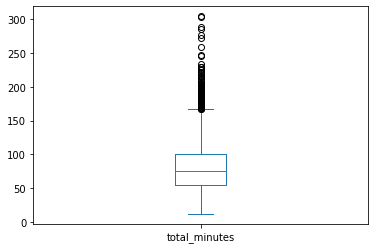

In [39]:
y.plot.box()

There are several outliers, with time over the ~170 min mark, that could affect training.
Models with regulatization like ElasticNet will be useful.


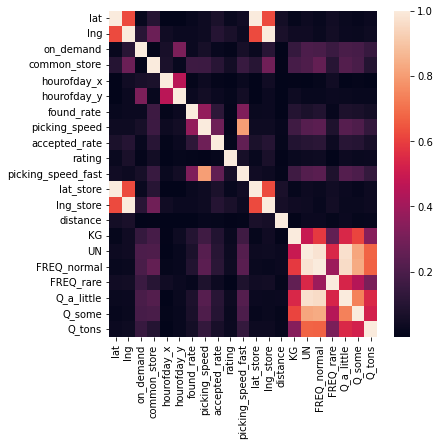

In [41]:
#Let's look at correlations
corr = X.corr().abs()

plt.figure(figsize = (6,6))
sns.heatmap(corr)
plt.show()

Coordinates are somewhat correlated, which makes sense since they're close to each other.
Frequencies and amounts also have some correlation, wich is also reasonable.
The low correlation indicates that it won't affect regression models.

Now let's prepare the categorical features

In [42]:
from sklearn.preprocessing import OneHotEncoder

catvars = X.dtypes.loc[X.dtypes == object].index

for var in catvars:
    # print(duf[var].value_counts())

    X[var] = [var + '_'  + x for x in X[var]]

    ohe = OneHotEncoder()
    A = pd.DataFrame(  ohe.fit_transform(X[[var]]).toarray(), columns = ohe.categories_[0] , index = X.index)

    X = X.merge(A[ohe.categories_[0]], left_index = True, right_index = True)


X.columns
X.drop(catvars, axis = 1, inplace = True)


Lets choose a few models to try

In [43]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = [("elastic_net", ElasticNet(random_state=semilla) ),
          ("RF", RandomForestRegressor(random_state=semilla, criterion="mae", n_jobs = -1)),
          ("svr", SVR())
          ]


Now let's do a K-Fold cross validation, to avoid overfitting due to choosing a specific split

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import clone

kf = KFold(n_splits=3)

for name, model in models:

    mae = []
    mse = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scale = StandardScaler()
        X_train_scaled = scale.fit_transform(X_train)
        X_test_scaled = scale.transform(X_test)

        reg = clone(model)
        reg.fit(X_train_scaled, y_train)
        ypred = reg.predict(X_test_scaled)

        mae.append( mean_absolute_error(y_test, ypred) )
        mse.append( mean_squared_error(y_test, ypred, squared=False) )

    print("MAE for " + name + ": mean is " + str(np.mean(mae)) + " and std " + str(np.std(mae)))
    print("RMSE for " + name + ": mean is " + str(np.mean(mse)) + " and std " + str(np.std(mse)))
    print("\n")

#EN 18.8/24.8
#RF 17.3/23
#SVR 19/26

MAE for elastic_net: mean is 18.78973405045916 and std 0.1761088547236602
RMSE for elastic_net: mean is 24.80664990921772 and std 0.299622527407083




C:\Users\franc\PycharmProjects\letstf2gpu\lib\site-packages\sklearn\ensemble\_forest.py:395: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\franc\PycharmProjects\letstf2gpu\lib\site-packages\sklearn\ensemble\_forest.py:395: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
C:\Users\franc\PycharmProjects\letstf2gpu\lib\site-packages\sklearn\ensemble\_forest.py:395: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


MAE for RF: mean is 17.309717099707726 and std 0.06638571038736005
RMSE for RF: mean is 23.03179814711473 and std 0.23693745210092568


MAE for svr: mean is 18.901351660799694 and std 0.4316590237068328
RMSE for svr: mean is 26.18242918751838 and std 0.695834338796511




Random Forest performed slightly better than ElasticNet and SVR. I used MAE for the loss function to avoid outliers
affecting the training too much.

Another important result: Since the std of all models is very small, all less than a minute, there's no concern of overfitting
due to choosing a specific split. Having checked that, I can use a more powerful technique:

Let's use gridsearch to find the optimal parameters


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

y_train.describe()
y_test.describe()


count    1561.000000
mean       80.888308
std        34.640143
min        11.969489
25%        55.458347
50%        73.846755
75%        99.284097
max       303.029792
Name: total_minutes, dtype: float64

In [55]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [56]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


#We use mae to avoid the outliers from affecting the training too much
reg = RandomForestRegressor(random_state=semilla, criterion = "mae")

# Number of trees in random forest
n_estimators = [10, 100, 200]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 20, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
params = {'n_estimators': n_estimators,
               # 'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


grid = GridSearchCV(estimator = reg, param_grid = params,
                    scoring = "neg_mean_absolute_error",
                    cv = 3, n_jobs = 15, verbose = 2)

In [ ]:
print("Working on gridsearch")

grid.fit(X_train_scaled, y_train)


In [ ]:
grid.best_params_

reg = grid.best_estimator_

The hyperparameter search with Gridsearch takes fairly long, hence I ran it offline.
Here are the best parameters found:

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}


In [73]:
regrf = RandomForestRegressor(random_state=semilla,
                             criterion = "mae",
                             bootstrap= True,
                             max_depth= 20,
                             min_samples_leaf= 4,
                             min_samples_split= 10,
                             n_estimators= 200
                             )
regrf.fit(X_train_scaled, y_train)

ypred = regrf.predict(X_test_scaled)

print( mean_absolute_error(y_test, ypred) )
print( mean_squared_error(y_test, ypred, squared=False) )

# 16.6366439997288
# 22.830708375098602

C:\Users\franc\PycharmProjects\letstf2gpu\lib\site-packages\sklearn\ensemble\_forest.py:395: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


16.63222584606518
22.82645980492681


Gridsearch helped reduce the MAE from 17.3 to 16.6 minutes, and RMSE 
from 23.0 to 22.8 minutes. Let's see the improvement in SVR


In [ ]:
# Now SVR gridsearch

from sklearn.svm import SVR
gsc = GridSearchCV(
        estimator=SVR(),
        param_grid={'kernel': ["rbf", "linear"],
            'C': [1, 100],
            'epsilon': [0.001, 1, 5],
            'gamma':["auto", "scale"]
        },
        cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=15)



gsc.fit(X_train_scaled, y_train)


In [ ]:
gsc.best_params_
reg = gsc.best_estimator_

Similar with gridsearch for SVR, I ran the calculation offline. 
Here are the best parameters:

{'C': 100, 'epsilon': 5, 'gamma': 'auto', 'kernel': 'rbf'}



In [64]:
regsvc = SVR(C= 100, epsilon= 5, gamma= 'auto', kernel= 'rbf')

regsvc.fit(X_train_scaled, y_train)

SVR(C=100, epsilon=5, gamma='auto')

In [65]:
ypred = regsvc.predict(X_test_scaled)

print( mean_absolute_error(y_test, ypred) )
print( mean_squared_error(y_test, ypred, squared=False) )

# 16.924572894720576
# 23.194546487539633

16.924570397711822
23.19454432848136


SVR is now almost as good as RF. Let's check ElasticNetCV.
ElasticNetCV loops over a range of l1 ratios to find the optimal value:

In [ ]:
from sklearn.linear_model import ElasticNetCV

reg = ElasticNetCV(l1_ratio= [.1, .5, .7, .9, .95, .99, 1], random_state = semilla )

reg.fit(X_train_scaled, y_train)
ypred = reg.predict(X_test_scaled)

print(reg.l1_ratio_)

print( mean_absolute_error(y_test, ypred) )
print( mean_squared_error(y_test, ypred, squared=False) )
# 17.880412062299204
# 24.09595343713386

Now let's try with ligthgbm.
Lightgbm handles categorial features, so let's avoid using one hot encoding

In [67]:
import lightgbm as lgb
# from lightgbm import LGBMRegressor
print(lgb.__version__)


dataOG.columns

catvars = dataOG.dtypes.loc[dataOG.dtypes == object].index

for var in catvars:

    dataOG[var] = dataOG[var].astype('category')

3.3.1


In [69]:
label = dataOG.pop("total_minutes")
Xlgb = dataOG.copy()


Xlgb["on_demand"] = Xlgb["on_demand"].astype(int)

X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(Xlgb, label, test_size=0.2, random_state=semilla)

In [70]:
train_data = lgb.Dataset(X_train_lgb, label = y_train_lgb)
eval_data = lgb.Dataset(X_test_lgb, label = y_test_lgb, reference = train_data)

X_test_lgb.columns.shape
X_train_lgb.columns.shape
X_test_lgb.dtypes

lat                    float64
lng                    float64
on_demand                int32
common_store             int64
timeofday             category
hourofday_x            float64
hourofday_y            float64
seniority             category
found_rate             float64
picking_speed          float64
accepted_rate          float64
rating                 float64
picking_speed_fast       int64
lat_store              float64
lng_store              float64
distance               float64
comuna                category
KG                     float64
UN                     float64
FREQ_normal            float64
FREQ_rare              float64
Q_a_little             float64
Q_some                 float64
Q_tons                 float64
dtype: object

In [71]:

parameters = {
        'objective': 'regression',
        'metric': 'mae',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_cat_to_onehot': 10,
        'bagging_freq': 10,
        'feature_fraction': 0.9,
        'n_jobs':9,
        'seed': semilla
    }

num_round = 1000
reg = lgb.train(params=parameters, train_set=train_data,
                num_boost_round=num_round,
                valid_sets=eval_data,
                early_stopping_rounds=5,
                verbose_eval=0)


y_pred = reg.predict(X_test_lgb, num_iteration=reg.best_iteration)

print( mean_absolute_error(y_test, ypred) )
print( mean_squared_error(y_test, ypred, squared=False) )

# 17.880412062299204
# 24.09595343713386

C:\Users\franc\PycharmProjects\letstf2gpu\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\franc\PycharmProjects\letstf2gpu\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\franc\PycharmProjects\letstf2gpu\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\franc\PycharmProjects\letstf2g

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 6241, number of used features: 24
[LightGBM] [Info] Start training from score 81.185779
17.880412062299154
24.095953437133872


Since lightgbm did fairly well, let's try to improve it with hyperparameter tuning


In [ ]:
model = lgb.LGBMRegressor(random_state=semilla)
param_dists = {
    "n_estimators": [400, 700, 1000],
    "colsample_bytree": [0.7, 0.8, 1],
    "max_depth": [-1, 15, 20, 25],
    "learning_rate":[0.01, 0.001],
    "num_leaves": [10, 100, 1000, 3000],
    "min_data_in_leaf":[100, 1000],
    "reg_alpha": [1.1, 1.2, 1.3],
    "reg_lambda": [1.1, 1.2, 1.3],
    "min_split_gain": [0., 1., 15.],
    "subsample": [0.7, 0.8, 0.9],
    "subsample_freq": [20],
    "random_state":[semilla]
}

gs = RandomizedSearchCV(estimator = model, param_distributions=param_dists,
                  n_iter=100,
                  scoring="neg_mean_absolute_error",
                  n_jobs=10,
                  cv=3,
                  random_state=semilla,
                  verbose=2
                  )
gs.fit(X_train_lgb, y_train_lgb)


ypred = gs.predict(X_test_lgb)

print( mean_absolute_error(y_test, ypred) )
print( mean_squared_error(y_test, ypred, squared=False) )

# 15.896987017506243
# 21.591355890477775

Here below are the best parameters I found with Gridsearch. 
This is the best model obtained thus far.

In [ ]:
gs.best_params_

"""
{'subsample_freq': 20,
 'subsample': 0.9,
 'reg_lambda': 1.1,
 'reg_alpha': 1.3,
 'random_state': 2077,
 'num_leaves': 1000,
 'n_estimators': 1000,
 'min_split_gain': 1.0,
 'min_data_in_leaf': 100,
 'max_depth': 15,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}
"""

In [72]:
reglgb =  lgb.LGBMRegressor(random_state=semilla,
                            subsample_freq= 20,
                             subsample= 0.9,
                             reg_lambda= 1.1,
                             reg_alpha= 1.3,
                             num_leaves= 1000,
                             n_estimators= 1000,
                             min_split_gain= 1.0,
                             min_data_in_leaf= 100,
                             max_depth= 15,
                             learning_rate= 0.01,
                             colsample_bytree= 0.7
                            )

reglgb.fit(X_train_lgb, y_train_lgb)

ypred = reglgb.predict(X_test_lgb)

print( mean_absolute_error(y_test, ypred) )
print( mean_squared_error(y_test, ypred, squared=False) )

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
15.896987017506243
21.591355890477775


## Model Explanation
Now that we have a great model, let's explain it! Let's find the most important features
and how they're used to make predictions.

First the random forest model with shap

In [74]:
import shap

explainer = shap.Explainer(regrf)
shap_values = explainer(X_test_scaled)

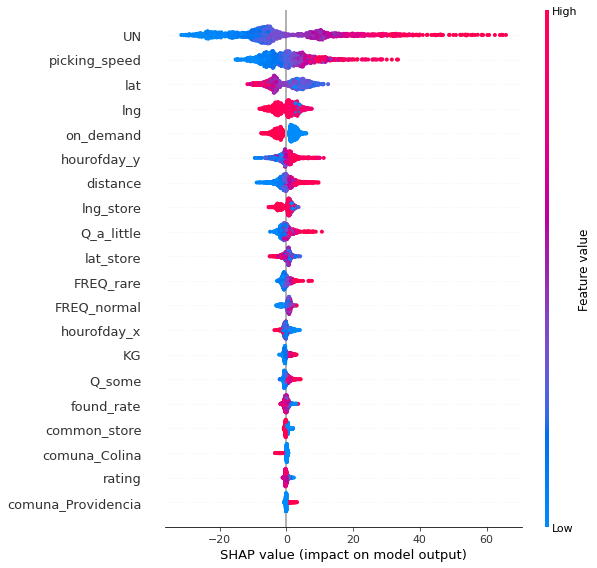

In [75]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns, )

Shap is very useful for the interpretation of the model. A high number of units bought (UN),
a slow shopper (picking speed), the hour of the day, a large distance to travel, buying rarely bought items (FREQ)
or a store not commonly used (common_store), buying a large weight (KG, Q_little and Q_some),
the location (coordinates, comuna), a low rating of the shopper,
all contribute to an increase in the time predicted.

Let's look at the feature importance according to Lightgbm:


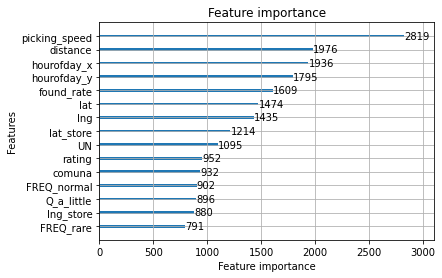

In [76]:
ax = lgb.plot_importance(reg, max_num_features=15)

It's interesting to notice that both models share similar features among the most important ones.

It's also good to notice that the features created were useful to the model, such as cyclical time,
distance, comuna, frequency of stores, quantity/amount of items bought, among some.


Now that I have the best model: lightgbm, let's use it to predict on the set I need to submit



In [77]:

catvars = finaltest.dtypes.loc[finaltest.dtypes == object].index

for var in catvars:

    finaltest[var] = finaltest[var].astype('category')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
finaltest.dtypes

total_minutes = finaltest.pop("total_minutes")

In [81]:
total_minutes_pred = reglgb.predict(finaltest)
total_minutes_pred

array([ 59.28570049,  68.30594305, 100.86793831, ...,  66.65374527,
        94.45950331,  82.82587466])

In [ ]:
total_minutes = total_minutes.to_frame("total_minutes_predicted")
total_minutes["total_minutes_predicted"] = total_minutes_pred
total_minutes.to_csv("total_minutes_predicted.csv")
total_minutes.to_excel("total_minutes_predicted.xlsx")

Thank you very much for this very interesting test,
I enjoyed being creative when designing new features and finding the best model.
I look forward to talking with you regarding
this position and answer any questions you might have.
Thank you very kindly for your consideration.

Sincerely,
Francisco Mena